In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the mnist dataset.
(original_train, original_test) = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [203]:
# Helper functions
def normalize_fn(img, label):
  return tf.cast(img, tf.float32) / 255.0, label

def filter_fn(img, label):
  # Only keep 0 and 1 examples.
  return tf.math.less_equal(label, tf.constant(1, dtype=tf.int64))

In [204]:
ds_train0 = original_train.filter(filter_fn).map(normalize_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test0 = original_test.filter(filter_fn).map(normalize_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [205]:
def model_fn1():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
  )
  return model

def model_fn2():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
  )
  return model

In [318]:
def adversarial_examples(model, ds, epsilon=0.01, max_adversarial_steps=100, batch_size=64):
  imgs_new = []
  labels_new = []
  steps = []
  norm = []
  ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  model.trainable = False
  for img, label in ds:
    size = img.shape[0]
    perturbation = tf.zeros([size, 28, 28, 1], dtype=tf.float32)
    found = np.zeros(size)
    img_new = img
    for i in range(max_adversarial_steps):
      img_new = tf.clip_by_value(tf.add(img_new, perturbation), clip_value_min=0, clip_value_max=1)
      with tf.GradientTape() as tape:
        tape.watch(img_new)
        prediction = model(img_new)
        loss = tf.keras.losses.BinaryCrossentropy()(label, prediction)
      diff = np.absolute(prediction.numpy().reshape(size) - label.numpy())
      for j in range(size):
        if diff[j] > 0.5 and found[j] == 0:
          found[j] = 1
          imgs_new.append(tf.reshape(img_new[j], [28, 28, 1]))
          labels_new.append(tf.cast(label.numpy()[j], tf.int64))
          steps.append(i)
          norm.append(tf.norm(tf.subtract(img[j], img_new[j])).numpy())
      if np.sum(found) == size:
        break
      gradient = tape.gradient(loss, img_new)
      perturbation = tf.sign(gradient) * epsilon
    #for k in range(size):
      #if found[k] == 0:
        # Can't find adversarial examples within max_adversarial_steps.
        #steps.append(max_adversarial_steps)
        #norm.append(tf.norm(tf.ones([28, 28, 1], dtype=tf.float32)).numpy())
  model.trainable = True
  return imgs_new, labels_new, np.mean(steps), np.mean(norm)



In [322]:
def adversarial_training(model_fn, ds_train0, ds_test0, iteration=3, epoch_per_iteration=5, epsilon=0.01, max_adversarial_steps=100, batch_size=64):
  '''
  args:
    model_fn: the function to create a new model.
    ds_train0: the original training dataset.
    ds_test0: the original test dataset.
  returns:
    models: the trained models.
    ds_train: the cumulative training datasets.
    histories: the model training histories.
    avg_adversarial_steps: the average steps to generate an adversarial example.
    avg_norm: the average norm of the perturbation.
    adversarial_found: the number of adversarial examples found in each iteration.
  '''
  models = []
  ds_train = [ds_train0]
  histories = []
  avg_adversarial_steps = []
  avg_norm = []
  adversarial_found = []
  test = ds_test0.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  for i in range(iteration):
    print('Running training in iteration {}:'.format(i))
    train = tf.data.experimental.sample_from_datasets(ds_train)
    train = train.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    model = model_fn()
    history = model.fit(train, epochs=epoch_per_iteration, validation_data=test)
    models.append(model)
    histories.append(history)
    print('Generating adversarial examples in iteration {}'.format(i))
    imgs_new, labels_new, steps, norm = adversarial_examples(model, ds_train0, epsilon=epsilon, max_adversarial_steps=max_adversarial_steps, batch_size=batch_size)
    if len(imgs_new) == 0:
      print('Could not generate any more adversarial examples at iteration {}'.format(i))
      break
    else:
      print('Avg steps: {}; avg norm: {}'.format(steps, norm))
    ds_train.append(tf.data.Dataset.from_tensor_slices((imgs_new, labels_new)))
    avg_adversarial_steps.append(steps)
    avg_norm.append(norm)
    adversarial_found.append(len(imgs_new))
  return models, ds_train, histories, avg_adversarial_steps, avg_norm, adversarial_found

In [321]:
models, ds_train, histories, avg_adversarial_steps, avg_norm, adv = adversarial_training(model_fn1, ds_train0, ds_test0, iteration=10, epoch_per_iteration=5)

Running training in iteration 0:
Epoch 1/5
198/198 [==============================] - 3s 14ms/step - loss: 0.0789 - binary_accuracy: 0.9789 - val_loss: 0.0044 - val_binary_accuracy: 0.9986
Epoch 2/5
198/198 [==============================] - 3s 14ms/step - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 0.0015 - val_binary_accuracy: 0.9995
Epoch 3/5
198/198 [==============================] - 3s 13ms/step - loss: 0.0015 - binary_accuracy: 0.9997 - val_loss: 0.0031 - val_binary_accuracy: 0.9995
Epoch 4/5
198/198 [==============================] - 3s 13ms/step - loss: 6.8099e-04 - binary_accuracy: 0.9999 - val_loss: 0.0042 - val_binary_accuracy: 0.9991
Epoch 5/5
198/198 [==============================] - 3s 13ms/step - loss: 0.0017 - binary_accuracy: 0.9994 - val_loss: 0.0023 - val_binary_accuracy: 0.9995
Generating adversarial examples in iteration 0
Avg steps: 13.975486827033219; avg norm: 2.7194321155548096
Running training in iteration 1:
Epoch 1/5
335/335 [========================

ValueError: ignored

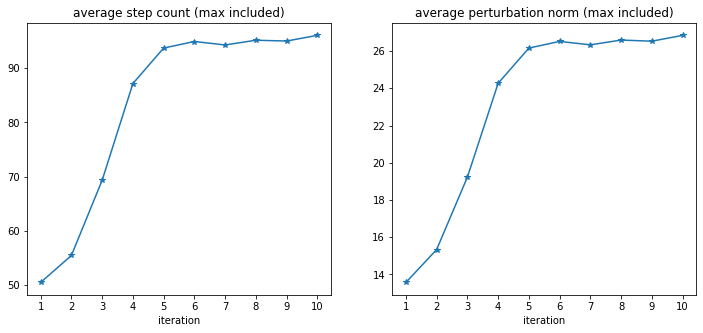

In [329]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
x = range(1, 11)
axs[0].plot(x, avg_adversarial_steps, '-*')
axs[0].set_xlabel('iteration')
axs[0].set_title('average step count (max included)')
axs[0].set_xticks(np.arange(min(x), max(x)+1, 1.0))
axs[1].plot(x, avg_norm, '-*')
axs[1].set_xlabel('iteration')
axs[1].set_title('average perturbation norm (max included)')
axs[1].set_xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

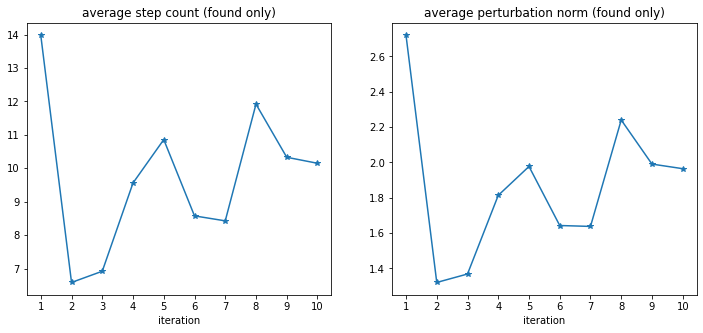

In [330]:
found_avg_adversarial_steps = [13.975486827033219, 6.5831792975970425, 6.918559794256322, 9.559090909090909, 10.856799037304452, 8.574365175332527, 8.425894378194208, 11.917491749174918, 10.328068043742405, 10.1484375]
found_avg_norm = [2.7194321155548096, 1.3199187517166138, 1.3677293062210083, 1.8132301568984985, 1.976809024810791, 1.6423959732055664, 1.6372220516204834, 2.240108013153076, 1.9903441667556763, 1.9642828702926636]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
x = range(1, 11)
axs[0].plot(x, found_avg_adversarial_steps, '-*')
axs[0].set_xlabel('iteration')
axs[0].set_title('average step count (found only)')
axs[0].set_xticks(np.arange(min(x), max(x)+1, 1.0))
axs[1].plot(x, found_avg_norm, '-*')
axs[1].set_xlabel('iteration')
axs[1].set_title('average perturbation norm (found only)')
axs[1].set_xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

In [324]:
total = 0.0
for img, label in ds_train0:
  total += 1
print(total)


12665.0


In [326]:
adv = []
for i in range(1, 11):
  t = 0.0
  for img, label in ds_train[i]:
    t += 1
  adv.append(t/total*100)

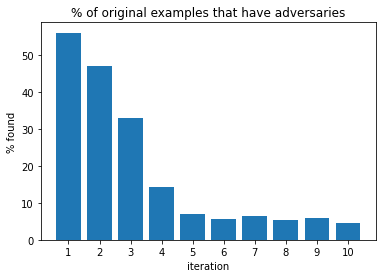

In [328]:
plt.bar(range(1, 11), adv)
plt.xticks(np.arange(1, 11, 1.0))
plt.xlabel('iteration')
plt.ylabel('% found')
plt.title('% of original examples that have adversaries')
plt.show()

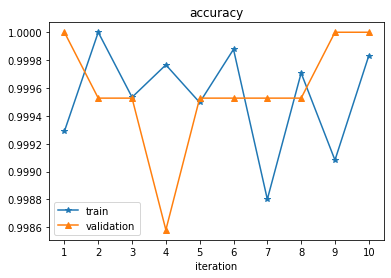

In [315]:
x = range(1, 11)
t_accuracy = [ x.history['binary_accuracy'][4] for x in histories]
v_accuracy = [ x.history['val_binary_accuracy'][4] for x in histories]
plt.plot(x, t_accuracy, '-*', label='train')
plt.plot(x, v_accuracy, '-^', label='validation')
plt.legend()
plt.xlabel('iteration')
plt.title('accuracy')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

In [292]:
def keep0(img, label):
  return tf.math.equal(label, tf.constant(0, dtype=tf.int64))
def keep1(img, label):
  return tf.math.equal(label, tf.constant(1, dtype=tf.int64))
print(len(ds_train))

11


In [307]:
def find_img(ds, models, filter_fn):
  '''
  Find and return images that have adversarial examples across the models.
  '''
  ds = ds.filter(filter_fn).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  for img, label in ds:
    d = tf.data.Dataset.from_tensor_slices((img, label))
    imgs = [img.numpy().reshape(28, 28)]
    for i in range(len(models)-1):
      imgs_new, labels_new, s, n = adversarial_examples(models[i], d)
      if len(imgs_new) == 0:
        break
      else:
        imgs.append(imgs_new[0].numpy().reshape(28, 28))
    if len(imgs) == len(models):
      return imgs
  return []


In [308]:
imgs = find_img(ds_train0, models, keep0)

In [311]:
def display(imgs):
  fig, axs = plt.subplots(2, 5, figsize=(20, 10))
  for i in range(10):
    row = int(i / 5)
    col = i % 5
    axs[row][col].imshow(imgs[i], cmap='gray')
    axs[row][col].axis('off')
    if i == 0:
      axs[row][col].set_title('original')
    else:
      axs[row][col].set_title('iteration {}'.format(i))
  plt.show()

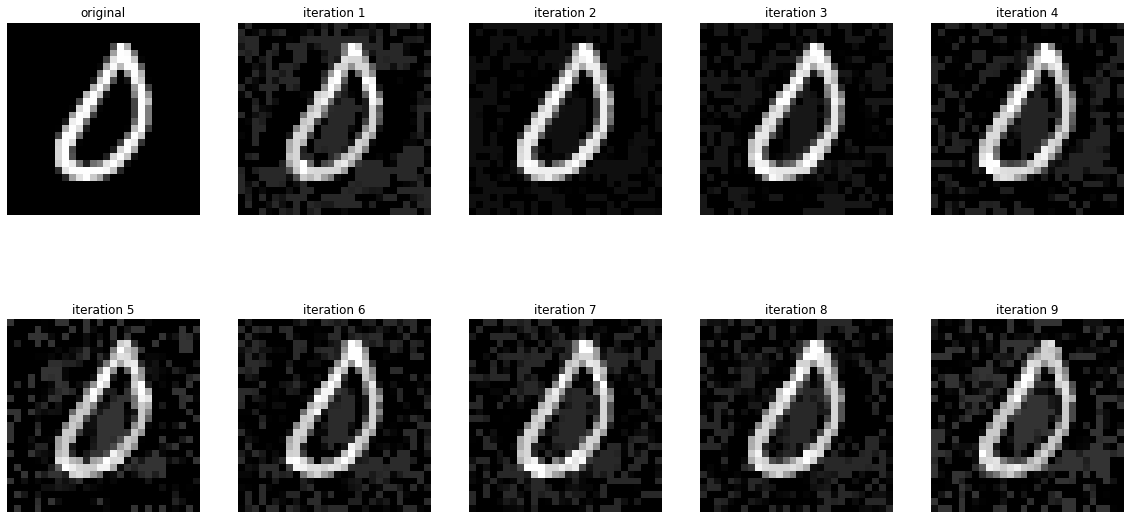

In [312]:
display(imgs)

In [313]:
imgs = find_img(ds_train0, models, keep1)

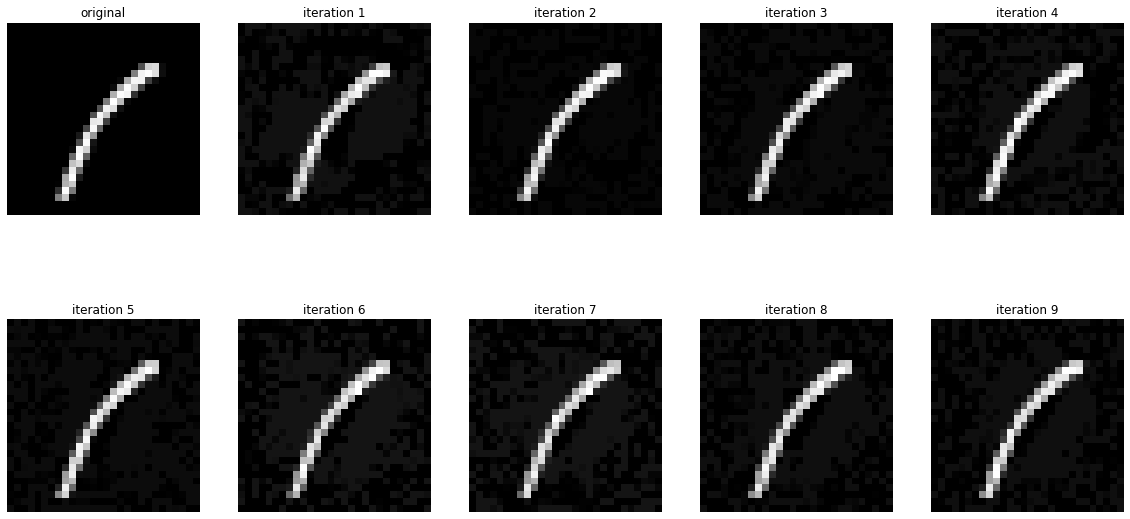

In [314]:
display(imgs)